# Курсовая работа по дисциплине “Технологии анализа данных и машинное обучение“

## Тема курсовой работы

Решение задач кластеризации тестов с помощью методов глубокого обучения

## Цель работы

Продемонстрировать владение основными навыками обучения и применения моделей глубокого обучения, владение основными инструментальными средствами библиотек языка программирования Python для глубокого обучения, в том числе фреймворком для глубокого обучения PyTorch, методами сбора и подготовки набора данных, анализа качества обучения модели глубокого обучения, умение делать выводы из проведенного анализа.


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
import random
import re

## Задачи для выполнения

1.	Выбрать (собрать) набор данных для анализа в соответствии с выбранной темой курсовой работы. Описать этот набор и решаемую задачу. Определить метрики качества для модели, определить типичный уровень метрик для решения аналогичных задач, установить ориентиры для метрики.

In [55]:
df = pd.read_excel('texts.xlsx')
df.head()

,text,label
0,"Полина составляет 4-буквенные коды из букв П, ...",0
1,"Петя составляет 6-буквенные коды из букв П, Е,...",0
2,"Иван составляет 5-буквенные коды из букв И, В,...",0
3,"Света составляет 5-буквенные коды из букв С, В...",0
4,Для передачи сообщений используются 5-буквенны...,0


2.	Провести предварительный анализ и очистку данных. Этот этап включает в себя вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной, вывод нескольких элементов данных для иллюстрации структуры данных.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    200 non-null    object
 1   label   200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [58]:
df.label.unique()

array([0, 1, 2, 3, 4, 5])

0 – информатика

1 – литература 

2 – биология 

3 – математика 

4 – русский язык 

5 - география

3.	При необходимости выполнить преобразование данных. Этот этап сильно зависит от типа исследуемых данных и может включать в себя токинизацию и векторизацию текста, извлечение признаков из данных, преобразование изображений в плоский численный массив и другие преобразования.

In [59]:
texts = df['text'].tolist()
keys = df['label'].tolist()

Следующий шаг - создание словаря, который будет использоваться для преобразования слов в числовые индексы. Это позволит использовать их в качестве входных данных для нашей модели.

In [ ]:
vocab = {}
for text in texts:
    for word in text.split():
        if word not in vocab:
            vocab[word] = len(vocab)

vocab

{'Полина': 0,
 'составляет': 1,
 '4-буквенные': 2,
 'коды': 3,
 'из': 4,
 'букв': 5,
 'П,': 6,
 'О,': 7,
 'Л,': 8,
 'И,': 9,
 'Н,': 10,
 'А.': 11,
 'Каждую': 12,
 'букву': 13,
 'можно': 14,
 'использовать': 15,
 'любое': 16,
 'количество': 17,
 'раз': 18,
 'или': 19,
 'совсем': 20,
 'не': 21,
 'использовать,': 22,
 'при': 23,
 'этом': 24,
 'нельзя': 25,
 'ставить': 26,
 'подряд': 27,
 'две': 28,
 'гласные': 29,
 'согласные.': 30,
 'Сколько': 31,
 'различных': 32,
 'кодов': 33,
 'может': 34,
 'составить': 35,
 'Полина?': 36,
 'Петя': 37,
 '6-буквенные': 38,
 'Е,': 39,
 'Т,': 40,
 'Я.': 41,
 'Петя?': 42,
 'Иван': 43,
 '5-буквенные': 44,
 'В,': 45,
 'А,': 46,
 'Н.': 47,
 'Буквы': 48,
 'в': 49,
 'коде': 50,
 'могут': 51,
 'повторяться,': 52,
 'все': 53,
 'буквы': 54,
 'обязательно,': 55,
 'но': 56,
 'И': 57,
 'нужно': 58,
 'хотя': 59,
 'бы': 60,
 'один': 61,
 'раз.': 62,
 'Иван?': 63,
 'Света': 64,
 'С,': 65,
 'С': 66,
 'Света?': 67,
 'Для': 68,
 'передачи': 69,
 'сообщений': 70,
 'использ

In [ ]:
len(vocab)

2737

Далее, создадим класс TestDataset для преобразования наших тестов в числовые индексы и создания пакетов данных для обучения. В качестве входных данных будем использовать последовательности числовых индексов, созданных из наших тестов. Также создадим функцию collate_fn, которая будет использоваться для создания пакетов данных с разной длиной последовательностей.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, texts, vocab):
        self.texts = texts
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        seq = [self.vocab[word] for word in text.split()]
        return seq

def collate_fn(batch):
    max_len = max(len(seq) for seq in batch)
    padded_seqs = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, seq in enumerate(batch):
        padded_seqs[i, :len(seq)] = torch.LongTensor(seq)
    return padded_seqs

Теперь мы можем создать экземпляр TestDataset и использовать DataLoader для создания пакетов данных для обучения.

In [ ]:
dataset = TestDataset(texts, vocab)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

Создадим класс RNNModel для определения архитектуры нашей модели. В данном случае мы будем использовать простой RNN с одним скрытым слоем.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        outputs, hidden =  self.rnn(embeddings)
        return outputs


In [ ]:
model = RNNModel(len(vocab), 16, 8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[:, :-1]
        labels = batch[:, 1:]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(-1, len(vocab)), labels.reshape(-1))
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


RuntimeError: ignored

##### Создаём Embeddings для дальнейшей векторизации тестов и модель которую будем обучать, модель будет базироваться на GRU

In [ ]:
class MyWordEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(MyWordEmbeddings, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)

    def forward(self, x):
        x = self.embedding(x)
        return x


class RNNClustering(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_clusters):
        super(RNNClustering, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_clusters)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.linear(out[:, -1, :])
        return out

##### Задаём Дата-сет, для начала будем его генерировать

##### Создание словаря и токенизация текстов

In [64]:
word2idx = {}
idx2word = {}
idx = 0
tokenized_texts = []

for text in texts:
    text = re.sub(r'[^а-яА-Я.,!?]', ' ', text.lower())
    tokens = text.split()
    tokenized_texts.append(tokens)
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx2word[idx] = token
            idx += 1

vocab_size = len(word2idx)

max_len = max([len(tokens) for tokens in tokenized_texts])
X = torch.zeros(len(tokenized_texts), max_len, dtype=torch.long)

for i, tokens in enumerate(tokenized_texts):
    for j, token in enumerate(tokens):
        X[i, j] = word2idx[token]

In [ ]:
word2idx

{'полина': 0,
 'составляет': 1,
 'буквенные': 2,
 'коды': 3,
 'из': 4,
 'букв': 5,
 'п,': 6,
 'о,': 7,
 'л,': 8,
 'и,': 9,
 'н,': 10,
 'а.': 11,
 'каждую': 12,
 'букву': 13,
 'можно': 14,
 'использовать': 15,
 'любое': 16,
 'количество': 17,
 'раз': 18,
 'или': 19,
 'совсем': 20,
 'не': 21,
 'использовать,': 22,
 'при': 23,
 'этом': 24,
 'нельзя': 25,
 'ставить': 26,
 'подряд': 27,
 'две': 28,
 'гласные': 29,
 'согласные.': 30,
 'сколько': 31,
 'различных': 32,
 'кодов': 33,
 'может': 34,
 'составить': 35,
 'полина?': 36,
 'петя': 37,
 'е,': 38,
 'т,': 39,
 'я.': 40,
 'петя?': 41,
 'иван': 42,
 'в,': 43,
 'а,': 44,
 'н.': 45,
 'буквы': 46,
 'в': 47,
 'коде': 48,
 'могут': 49,
 'повторяться,': 50,
 'все': 51,
 'обязательно,': 52,
 'но': 53,
 'и': 54,
 'нужно': 55,
 'хотя': 56,
 'бы': 57,
 'один': 58,
 'раз.': 59,
 'иван?': 60,
 'света': 61,
 'с,': 62,
 'с': 63,
 'света?': 64,
 'для': 65,
 'передачи': 66,
 'сообщений': 67,
 'используются': 68,
 'коды.': 69,
 'кодах': 70,
 'разрешается': 

Epoch 1 Loss = 1.8800
Epoch 2 Loss = 0.0008
Epoch 3 Loss = 0.0112
Epoch 4 Loss = 0.0004
Epoch 5 Loss = 0.0004
Epoch 6 Loss = 0.0004
Epoch 7 Loss = 0.0003
Epoch 8 Loss = 0.0003
Epoch 9 Loss = 0.0003
Epoch 10 Loss = 0.0003
Adjusted Rand index = 0.05
F1 score = 0.17


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


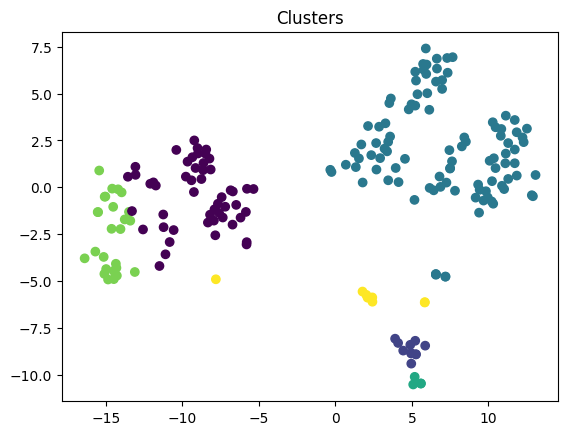

In [ ]:
# Создание модели
embedding_size = 64
hidden_size = 64
num_layers = 3
num_clusters = len(set(keys))

word_embeddings = MyWordEmbeddings(vocab_size, embedding_size)
model = RNNClustering(embedding_size, hidden_size, num_layers, num_clusters)

# Обучение модели
batch_size = 4
lr = 0.01
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr)
ce_loss = nn.CrossEntropyLoss()

dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

f_one = nn

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs in dataloader:
        optimizer.zero_grad()
        embeddings = word_embeddings(inputs[0])
        outputs = model(embeddings)
        loss = ce_loss(outputs, outputs.max(1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {}".format(epoch + 1), "Loss = {:.4f}".format(running_loss))


embeddings = word_embeddings(X)
with torch.no_grad():
    outputs = model(embeddings).numpy()
    pred_keys = KMeans(n_clusters=num_clusters).fit_predict(outputs)
    print("Adjusted Rand index = {:.2f}".format(metrics.adjusted_rand_score(keys, pred_keys)))
    print("F1 score = {:.2f}".format(metrics.f1_score(keys, pred_keys, average='weighted')))

tsne = TSNE(n_components=2, perplexity=len(outputs)/num_clusters)
embeddings_tsne = tsne.fit_transform(outputs)

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=pred_keys)
plt.title("Clusters")
plt.show()

Epoch 1 Loss = 2.1498
Epoch 2 Loss = 0.0088
Epoch 3 Loss = 0.0063
Epoch 4 Loss = 0.0047
Epoch 5 Loss = 0.0036
Epoch 6 Loss = 0.0029
Epoch 7 Loss = 0.0024
Epoch 8 Loss = 0.0020
Epoch 9 Loss = 0.0017
Epoch 10 Loss = 0.0014
Adjusted Rand index = 0.04
F1 score = 0.11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


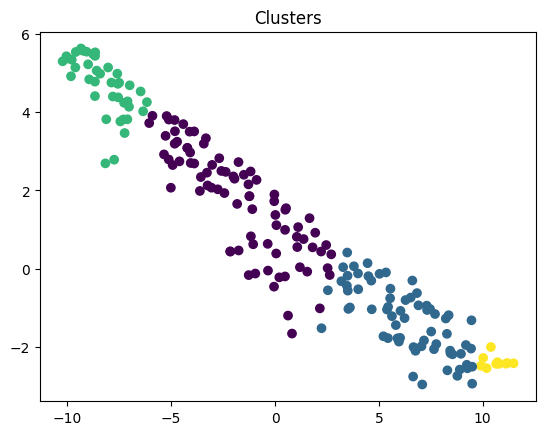

In [ ]:
# Создание модели
embedding_size = 64
hidden_size = 64
num_layers = 3
num_clusters = 4

word_embeddings = MyWordEmbeddings(vocab_size, embedding_size)
model = RNNClustering(embedding_size, hidden_size, num_layers, num_clusters)

# Обучение модели
batch_size = 4
lr = 0.005
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr)
ce_loss = nn.CrossEntropyLoss()

dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

f_one = nn

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs in dataloader:
        optimizer.zero_grad()
        embeddings = word_embeddings(inputs[0])
        outputs = model(embeddings)
        loss = ce_loss(outputs, outputs.max(1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch {}".format(epoch + 1), "Loss = {:.4f}".format(running_loss))


embeddings = word_embeddings(X)
with torch.no_grad():
    outputs = model(embeddings).numpy()
    pred_keys = KMeans(n_clusters=num_clusters).fit_predict(outputs)
    print("Adjusted Rand index = {:.2f}".format(metrics.adjusted_rand_score(keys, pred_keys)))
    print("F1 score = {:.2f}".format(metrics.f1_score(keys, pred_keys, average='weighted')))

tsne = TSNE(n_components=2, perplexity=len(outputs)/num_clusters)
embeddings_tsne = tsne.fit_transform(outputs)

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=pred_keys)
plt.title("Clusters")
plt.show()

In [ ]:
print("Adjusted Rand index = {:.2f}".format(metrics.adjusted_rand_score(keys, pred_keys)))
print("F1 score = {:.2f}".format(metrics.f1_score(keys, pred_keys, average='weighted')))

Adjusted Rand index = 0.11
F1 score = 0.14


In [60]:
def train_and_cluster_model(X, keys, embedding_size=64, hidden_size=64, num_layers=3, num_clusters = 4, ):
    vocab_size = max([max(x) for x in X]) + 1

    word_embeddings = MyWordEmbeddings(vocab_size, embedding_size)
    model = RNNClustering(embedding_size, hidden_size, num_layers, num_clusters)

    batch_size = 4
    lr = 0.01
    num_epochs = 10
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()

    dataset = TensorDataset(X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs in dataloader:
            optimizer.zero_grad()
            embeddings = word_embeddings(inputs[0])
            outputs = model(embeddings)
            loss = ce_loss(outputs, outputs.max(1)[1])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print("Epoch {}".format(epoch + 1), "Loss = {:.4f}".format(running_loss))

    embeddings = word_embeddings(X)
    with torch.no_grad():
        outputs = model(embeddings).numpy()
        pred_keys = KMeans(n_clusters=num_clusters).fit_predict(outputs)
        print("Adjusted Rand index = {:.2f}".format(metrics.adjusted_rand_score(keys, pred_keys)))
        print("F1 score = {:.2f}".format(metrics.f1_score(keys, pred_keys, average='weighted')))

    tsne = TSNE(n_components=2, perplexity=len(outputs) / num_clusters)
    embeddings_tsne = tsne.fit_transform(outputs)
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=pred_keys)
    plt.title("Clusters")
    plt.show()

    return model

Epoch 1 Loss = 1.4643
Epoch 2 Loss = 0.0013
Epoch 3 Loss = 0.0011
Epoch 4 Loss = 0.0009
Epoch 5 Loss = 0.0008
Epoch 6 Loss = 0.0007
Epoch 7 Loss = 0.0006
Epoch 8 Loss = 0.0005
Epoch 9 Loss = 0.0005
Epoch 10 Loss = 0.0004
Adjusted Rand index = 0.04
F1 score = 0.16


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


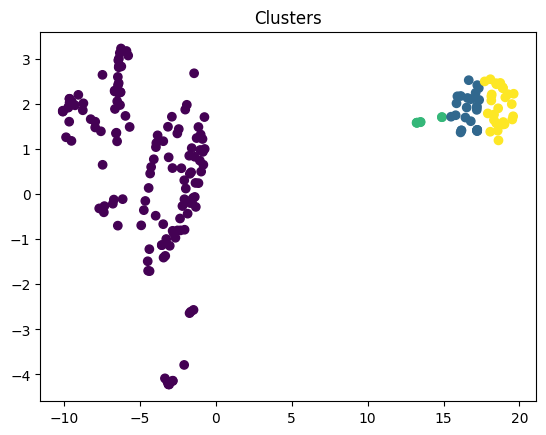

In [61]:
model = train_and_cluster_model(X, keys, embedding_size=64, hidden_size=64, num_layers=3, num_clusters=4)
